## Herschel-ATLAS Data Release III - Identifications [10 arcsec]

This notebook presents the identification process used to identify VIKING counterparts to Herschel sources.

### Imports

In [1]:
# Dependencies
import utils
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pandas as pd
from tqdm import tqdm
from lmfit import Model
from astropy import units as u
from astropy.table import Table
utils.rcparams()

### Choose Search Radius

Here we use our "change search radius" function to change the Herschel data file and the background file to a given
search radius.

In [2]:
R = 10
# As the original data file is already 15", we do not need to use these lines in this notebook
#utils.change_radius('Background_VIKING_KiDS_HELP', 'UPLOAD_RA', 'GroupID', 'GroupSize', 'DISTANCE', additional_cols=3, r=R)
#utils.change_radius('Herschel_VIKING_KiDS_HELP', 'IDNAME', 'GroupID', 'GroupSize', 'DISTANCE', additional_cols=33, r=R)

# Loading the datasets
background = utils.full_loader('Background_VIKING_KiDS_HELP_10')
data = utils.full_loader('Herschel_VIKING_KiDS_HELP_10')


C:\Users\bradl\AppData\Local\Temp/ipykernel_15524/2199512156.py:7: DtypeWarning: Columns (3,21,26,43) have mixed types.Specify dtype option on import or set low_memory=False.
  background = utils.full_loader('Background_VIKING_KiDS_HELP_10')


### Star-Galaxy Classifier

In this section we use an altered version of the Baldry et al, 2010 method to classify stars and galaxies.
Our classification systems uses the following key:

    0 - Star based on stellar probability > 0.95
    1 - Galaxy based on J-K/g-i colour-colour plot
    2 - Star based on J-K/g-i colour-colour plot
    3 - Galaxy based on J-K > something
    4 - Star based on J-K < something
    5 - Star based on stellar probability > 0.7
    6 - Galaxy based on all other

In [3]:
# Adding a column for star-galaxy classification of background and data objects
background['SG_key'] = utils.classification(background, 'IAUNAME', 'JAPERMAG3', 'KSAPERMAG3', 'MAG_GAAP_g', 'MAG_GAAP_i', 'PSTAR')
data['SG_key'] = utils.classification(data, 'IAUNAME', 'JAPERMAG3', 'KSAPERMAG3', 'MAG_GAAP_g', 'MAG_GAAP_i', 'PSTAR')

# A simplified key for just star/galaxy
def condition(flag):
    if m.isnan(flag): return np.nan
    elif (flag == 1) | (flag == 3) | (flag == 6): return 1
    else: return 0

background['SG'] = [condition(flag) for flag in background['SG_key']]
data['SG'] = [condition(flag) for flag in data['SG_key']]

Star-Galaxy Classification: 100%|██████████| 584565/584565 [00:09<00:00, 64472.95it/s]


In [4]:
# Print outs of the number of objects classified in different ways
galaxy = [flag for flag in data['SG'] if flag == 1]
star = [flag for flag in data['SG'] if flag == 0]
star_p95 = [flag for flag in data['SG_key'] if (flag == 0)]
galaxy_KiDS = [flag for flag in data['SG_key'] if (flag == 1)]
star_KiDS = [flag for flag in data['SG_key'] if (flag == 2)]
galaxy_JK = [flag for flag in data['SG_key'] if (flag == 3)]
star_JK = [flag for flag in data['SG_key'] if (flag == 4)]
star_p70 = [flag for flag in data['SG_key'] if (flag == 5)]
galaxy_other = [flag for flag in data['SG_key'] if (flag == 6)]

print("Number of galaxies = {:.0f}".format(len(galaxy)))
print("Number of stars = {:.0f}".format(len(star)))
print("Number of stars with p(>0.95) = {:.0f}".format(len(star_p95)))
print("Number of galaxies from KiDS colour-colour = {:.0f}".format(len(galaxy_KiDS)))
print("Number of stars from KiDS colour-colour = {:.0f}".format(len(star_KiDS)))
print("Number of galaxies from J-K > constant = {:.0f}".format(len(galaxy_JK)))
print("Number of stars from J-K < constant = {:.0f}".format(len(star_JK)))
print("Number of stars with p(>0.70) = {:.0f}".format(len(star_p70)))
print("Number of galaxies (other) = {:.0f}".format(len(galaxy_other)))

print("The constant defining J-K > constant = {:.4f}".format(utils.stellar_locus(1000, 0.2)))
print("The constant defining J-K < constant = {:.4f}".format(utils.stellar_locus(0, 0.2)))

Number of galaxies = 480320
Number of stars = 94355
Number of stars with p(>0.95) = 22315
Number of galaxies from KiDS colour-colour = 200566
Number of stars from KiDS colour-colour = 52126
Number of galaxies from J-K > constant = 67817
Number of stars from J-K < constant = 135
Number of stars with p(>0.70) = 19779
Number of galaxies (other) = 211937
The constant defining J-K > constant = 0.9768
The constant defining J-K < constant = 0.4228


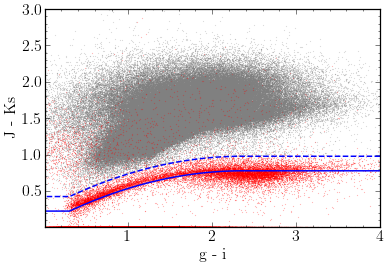

In [5]:
# Plot of the star-galaxy classification
gi_range = np.linspace(-3, 5, 1000)
jk_rangelocus = [utils.stellar_locus(i, 0) for i in gi_range]
jk_rangecut = [utils.stellar_locus(i, 0.2) for i in gi_range]

# Separation of stars and galaxies for the plot
galaxies = data[data['SG'] == 1]
stars = data[data['SG'] == 0]

# Separation of stars and galaxies in background for future reference
galaxies_back = background[background['SG'] == 1]
stars_back = background[background['SG'] == 0]

plt.figure()
plt.scatter(galaxies['MAG_GAAP_g'] - galaxies['MAG_GAAP_i'], galaxies['JAPERMAG3'] - galaxies['KSAPERMAG3'], s = 0.01, color = 'gray', rasterized = True)
plt.scatter(stars['MAG_GAAP_g'] - stars['MAG_GAAP_i'], stars['JAPERMAG3'] - stars['KSAPERMAG3'], s = 0.01, color = 'r', rasterized = True)
plt.plot(gi_range, jk_rangelocus, linestyle = '-', linewidth = 1.5, color = 'b')
plt.plot(gi_range, jk_rangecut, linestyle = '--', linewidth = 1.5, color = 'b')
plt.xlabel('g - i')
plt.ylabel('J - Ks')
plt.xlim(0.01, 4)
plt.ylim(0.01, 3)
plt.show()

### Determining Constants

Determining the value of Q and $\sigma_{\textrm{pos}}$. We determine the value of Q by counting the number of blank sources we observe in the datafile and in the background.
This split into all possible candidates and extragalactic candidates. Note that we sum up three components (0, 1 and multi);
this represents whether there is a blank because no object is found (0), there is a blank but with 1 object outside the current search radius (1) or multiple objects all of which are outside the current search radius (multi).

#### Determining $Q_0$

Remember that to determine $Q_0$ you need to have the full data for however far you estimate Q to (i.e. the full 15").
We shall therefore take the values from the 15" notebook:

In [6]:
# Values taken from the 15" notebook
r_range = np.linspace(0, 14, 15)
blanks = [1.0000284127568544, 0.9116524551040623, 0.7110542493245415, 0.5209059085576443, 0.38367480259647885, 0.2948681019951734, 0.2385641231148514, 0.2032051779006421, 0.18104163523085431, 0.166468711802521, 0.15637061963413298, 0.15064466562458204, 0.14550540438937284, 0.14157921652311542, 0.14195663454092533]
blanks_gals = [1.2275301418707854, 1.119766910360169, 0.8763487304030766, 0.6467075992367098, 0.47920215638339264, 0.3688305759558838, 0.2984028518139342, 0.2513348380138166, 0.22178450333553076, 0.20118553498974195, 0.1859701168048243, 0.17621442194666295, 0.16988014494727005, 0.16038747914724677, 0.15596240725722615]
data_blanks = [1.0, 0.8981640804642246, 0.6713791874002077, 0.4606540689412847, 0.3112175562066275, 0.21535496339012128, 0.15375632340706982, 0.11343636805200308, 0.08603450681300284, 0.06619748148837114, 0.05110398032315904, 0.0398083988280705, 0.030641719243309717, 0.023392084825373204, 0.01814733861425021]
background_blanks = [0.9999715880504075, 0.9852044772497233, 0.9442024824940957, 0.8843325855466044, 0.8111493225525769, 0.7303433702491373, 0.6445073190365982, 0.5582356179303078, 0.47521945271482097, 0.39765719798985455, 0.3268131855122734, 0.26425362400336205, 0.2105881865481257, 0.16522258986758848, 0.12783719952883518]

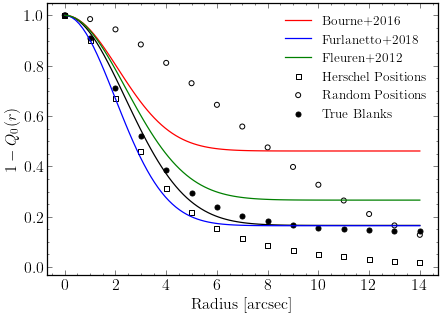

Best fitting value of Q0 (All) = 0.835 +- 0.009
Best fitting value of Q0 (Galaxies) = 0.823 +- 0.031
Best fitting value of sigma(pos) = 2.388 +- 0.065


In [7]:
# Create a model for our 1-Q0 distribution
bmodel = Model(utils.B)
params = bmodel.make_params(sigma = 2, Q0 = 0.8)

# Define model parameters and fit the model
params['sigma'].vary = True
params['Q0'].vary = True
fit_result = bmodel.fit(blanks, params, r = r_range)
fit_result_gals = bmodel.fit(blanks_gals, params, r = r_range)

# Determine the best fitting values of parameters
sigma_pos, sigma_pos_err = fit_result.params['sigma'].value, fit_result.params['sigma'].stderr
q0, q0_err = fit_result.params['Q0'].value, fit_result.params['Q0'].stderr
q0_gals, q0_gals_err = fit_result_gals.params['Q0'].value, fit_result_gals.params['Q0'].stderr
q0_stars = q0 - q0_gals

# Plot of the best fitting values and literature estimates
plot_rrange = np.linspace(0, 14, 100)
plt.figure(figsize = (7, 5))
plt.scatter(r_range, data_blanks, marker = 's', s = 25, facecolor= 'none', color = 'k', label = 'Herschel Positions')
plt.scatter(r_range, background_blanks, marker = 'o', s = 25, facecolor= 'none', color ='k', label = 'Random Positions')
plt.scatter(r_range, blanks, s = 25, color = 'k', label = 'True Blanks')
plt.plot(plot_rrange, utils.B(plot_rrange, sigma_pos, q0))
plt.plot(plot_rrange, utils.B(plot_rrange, 2.10, 0.5390), color = 'r', label = r'Bourne+2016')
plt.plot(plot_rrange, utils.B(plot_rrange, 1.99, 0.8360), color = 'b', label = r'Furlanetto+2018')
plt.plot(plot_rrange, utils.B(plot_rrange, 2.40, 0.7342), color = 'g',  label = r'Fleuren+2012')
plt.xlabel(r'Radius [arcsec]')
plt.ylabel(r'$1 - Q_0(r)$')
plt.legend()
plt.show()

print(r'Best fitting value of Q0 (All) = {:.3f} +- {:.3f}'.format(q0, q0_err))
print(r'Best fitting value of Q0 (Galaxies) = {:.3f} +- {:.3f}'.format(q0_gals, q0_gals_err))
print(r'Best fitting value of sigma(pos) = {:.3f} +- {:.3f}'.format(sigma_pos, sigma_pos_err))


#### Determining k

In [8]:
# Gather just unique rows in data, so we are calculating k over just the sources
unique_sources = data.drop_duplicates(subset = 'IDNAME')
unique_sources = unique_sources.reset_index()

# Computing the median k value
FWHM = 18.1
k_values = utils.K(unique_sources, FWHM, sigma_pos, 'F250BEST', 'E250BEST')
k_const = np.nanmedian(k_values)
print('Best fitting value of k = {:.3f}'.format(k_const))


Calculating K-constant values: 100%|██████████| 193527/193527 [00:01<00:00, 169651.30it/s]

Best fitting value of k = 0.663


### Likelihood Ratio Method

*** Some description to go here ***

#### K-band Distributions

C:\Users\bradl\Desktop\HerschelATLASDR3_2\utils\likelihood_ratio.py:67: RuntimeWarning: invalid value encountered in true_divide
  q_over_n = q / n_normalized
C:\Users\bradl\Desktop\HerschelATLASDR3_2\utils\likelihood_ratio.py:67: RuntimeWarning: divide by zero encountered in true_divide
  q_over_n = q / n_normalized


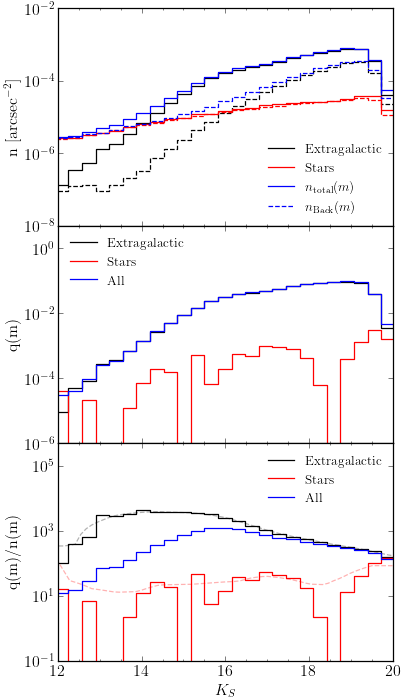

In [9]:
# Constants
ndata = 193527
nback = 844715

# Generate the n distributions
bin_centres, n_real, n_data_normalized, n_back_normalized = utils.N(data, background, Ndata = ndata, Nback = nback, r = R, band = 'KSAPERMAG3')
_, n_real_gals, n_data_normalized_gals, n_back_normalized_gals = utils.N(galaxies, galaxies_back, Ndata = ndata, Nback = nback, r = R, band = 'KSAPERMAG3')
_, n_real_stars, n_data_normalized_stars, n_back_normalized_stars = utils.N(stars, stars_back, Ndata = ndata, Nback = nback, r = R, band = 'KSAPERMAG3')

# Generate the q/n distributions
mag_range, q, qn, interp_qn = utils.q_div_n(n_real, n_back_normalized, q0, bin_centres, window_size = 3)
_, q_gals, qn_gals, interp_qn_gals = utils.q_div_n(n_real_gals, n_back_normalized_gals, q0_gals, bin_centres, window_size = 3)
_, q_stars, qn_stars, interp_qn_stars = utils.q_div_n(n_real_stars, n_back_normalized_stars, q0_stars, bin_centres, window_size = 5)


# Plot of the n, q and q/n distributions for the data and background for both stars, galaxies and all objects
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True, sharey=False, figsize = (6, 12))
fig.subplots_adjust(hspace = 0)

ax1.step(bin_centres, n_data_normalized_gals, where = 'mid', color = 'k', label =  r'Extragalactic')
ax1.step(bin_centres, n_back_normalized_gals, where = 'mid', color = 'k', linestyle = '--')
ax1.step(bin_centres, n_data_normalized_stars, where = 'mid', color = 'r', label =  r'Stars')
ax1.step(bin_centres, n_back_normalized_stars,  where = 'mid', color = 'r', linestyle = '--')
ax1.step(bin_centres, n_data_normalized, where = 'mid', color = 'b', label = r'$n_{\mathrm{total}}(m)$')
ax1.step(bin_centres, n_back_normalized, where = 'mid', color = 'b', linestyle = '--', label =  r'$n_{\mathrm{Back}}(m)$')
ax1.set_ylabel(r'n [arcsec$^{-2}$]')
ax1.legend()
ax1.set_ylim(1e-8, 1e-2)
ax1.semilogy()

ax2.step(bin_centres, q_gals, where = 'mid', color = 'k', label = 'Extragalactic')
ax2.step(bin_centres, q_stars, where = 'mid', color = 'r', label = 'Stars')
ax2.step(bin_centres, q, where = 'mid', color = 'b', label = 'All')
ax2.set_ylabel(r'q(m)')
ax2.legend()
ax2.set_ylim(1e-6, 5e0)
ax2.semilogy()

ax3.plot(mag_range, interp_qn_gals, color = 'k', alpha = 0.3, linestyle = '--')
ax3.plot(mag_range, interp_qn_stars, color = 'r', alpha = 0.3, linestyle = '--')
ax3.step(bin_centres, qn_gals, where = 'mid', color = 'k', label = 'Extragalactic')
ax3.step(bin_centres, qn_stars,  where = 'mid', color = 'r', label = 'Stars')
ax3.step(bin_centres, qn, where = 'mid', color = 'b', label = 'All')
ax3.set_xlabel(r'$K_S$')
ax3.set_ylabel(r'q(m)/n(m)')
ax3.legend()
ax3.set_xlim(12, 20)
ax3.set_ylim(1e-1, 5e5)
ax3.semilogy()

plt.show()

In [29]:
qn_stars_tuple

(array([ 9.        ,  9.13131313,  9.26262626,  9.39393939,  9.52525253,
         9.65656566,  9.78787879,  9.91919192, 10.05050505, 10.18181818,
        10.31313131, 10.44444444, 10.57575758, 10.70707071, 10.83838384,
        10.96969697, 11.1010101 , 11.23232323, 11.36363636, 11.49494949,
        11.62626263, 11.75757576, 11.88888889, 12.02020202, 12.15151515,
        12.28282828, 12.41414141, 12.54545455, 12.67676768, 12.80808081,
        12.93939394, 13.07070707, 13.2020202 , 13.33333333, 13.46464646,
        13.5959596 , 13.72727273, 13.85858586, 13.98989899, 14.12121212,
        14.25252525, 14.38383838, 14.51515152, 14.64646465, 14.77777778,
        14.90909091, 15.04040404, 15.17171717, 15.3030303 , 15.43434343,
        15.56565657, 15.6969697 , 15.82828283, 15.95959596, 16.09090909,
        16.22222222, 16.35353535, 16.48484848, 16.61616162, 16.74747475,
        16.87878788, 17.01010101, 17.14141414, 17.27272727, 17.4040404 ,
        17.53535354, 17.66666667, 17.7979798 , 17.9

#### Likelihood Values

In [10]:
# Generate tuples for q/n distributions and calculate LR values
qn_gal_tuple = (mag_range, interp_qn_gals)
qn_stars_tuple = (mag_range, interp_qn_stars)
likelihoods = utils.likelihood(data, 'IAUNAME', 'F250BEST', 'E250BEST', 'SG', 'DISTANCE', 'KSAPERMAG3', k_const, FWHM, qn_gal_tuple, qn_stars_tuple)

# Assign a new column to the data
data['likelihood'] = likelihoods


Likelihood Ratio calculations: 100%|██████████| 584565/584565 [00:25<00:00, 23042.39it/s]


#### Reliability Values

In [11]:
# Calculate the reliability values and assign a new column to the data
reliabilities = utils.reliability(data, 'IAUNAME', 'GroupID', 'likelihood', q0)
data['reliability'] = reliabilities

# Determining the largest reliability counterpart for each group
sources = data.sort_values(['reliability', 'DISTANCE'], ascending=[False, True]).drop_duplicates(['IDNAME'])

Reliability calculations: 100%|██████████| 584565/584565 [00:06<00:00, 83572.44it/s]


### Identification Statistics

In [12]:
# The number of sources with SNR(250) > 4
snr250 = [snr for snr in (sources['F250BEST']/sources['E250BEST']) if snr >= 4]
n_snr250 = len(snr250)
print("Number of sources with SNR 250 > 4 = {:.0f}".format(n_snr250))


# The number of sources that have multiple counterparts
sources_multi = [groupid for groupid in sources['GroupID'] if m.isnan(groupid) == False]
n_sources_multi = len(sources_multi)
print("Number of sources with multiple counterparts = {:.0f}".format(n_sources_multi))


# The number of sources with at least one possible counterpart
sources_one = [counterpart_id for counterpart_id in sources['IAUNAME'] if pd.isnull(counterpart_id) == False]
n_sources_one = len(sources_one)
print("Number of sources with at least one possible counterpart = {:.0f}".format(n_sources_one))


# The number of sources with at least one possible counterpart with SNR(250) > 4
sources_one_snr250 = [counterpart_id for counterpart_id,snr in zip(sources['IAUNAME'], (sources['F250BEST']/sources['E250BEST'])) if (pd.isnull(counterpart_id) == False) & (snr > 4)]
n_sources_one_snr250 = len(sources_one_snr250)
print("Number of sources with at least one possible counterpart with SNR 250 > 4 = {:.0f}".format(n_sources_one_snr250))


# The number of sources with at least one possible counterpart that is matched to a galaxy
sources_one_gal = [counterpart_id for counterpart_id,flag in zip(sources['IAUNAME'], sources['SG']) if (counterpart_id != 0) & (flag == 1)]
n_sources_one_gal = len(sources_one_gal)
print("Number of sources with at least one possible counterpart that is matched to a galaxy = {:.0f}".format(n_sources_one_gal))


# The number of sources with at least one possible counterpart that is matched to a star
sources_one_star = [counterpart_id for counterpart_id,flag in zip(sources['IAUNAME'], sources['SG']) if (counterpart_id != 0) & (flag == 0)]
n_sources_one_star = len(sources_one_star)
print("Number of sources with at least one possible counterpart that is matched to a star = {:.0f}".format(n_sources_one_star))


# The number of sources matched to a reliable counterpart
sources_rel = [reliability for reliability in sources['reliability'] if reliability > 0.8]
n_sources_rel = len(sources_rel)
print("Number of sources matched to a reliable counterpart = {:.0f}".format(n_sources_rel))


# The number of sources matched to a reliable galaxy
sources_rel_gal = [reliability for reliability,flag in zip(sources['reliability'], sources['SG']) if (reliability > 0.8) & (flag == 1)]
n_sources_rel_gal = len(sources_rel_gal)
print("Number of sources matched to a reliable galaxy = {:.0f}".format(n_sources_rel_gal))


# The number of sources matched to a reliable star
sources_rel_star = [reliability for reliability,flag in zip(sources['reliability'], sources['SG']) if (reliability > 0.8) & (flag == 0)]
n_sources_rel_star = len(sources_rel_star)
print("Number of sources matched to a reliable star = {:.0f}".format(n_sources_rel_star))


# The number of sources with LR > 0.66 but R < 0.8
sources_multi_LR = [likelihood for likelihood,reliability in zip(sources['likelihood'], sources['reliability']) if (likelihood > 0.66) & (reliability < 0.8)]
n_sources_multi_LR = len(sources_multi_LR)
print("Number of sources with LR > 0.66 but R < 0.8 = {:.0f}".format(n_sources_multi_LR))

Number of sources with SNR 250 > 4 = 182282
Number of sources with multiple counterparts = 146374
Number of sources with at least one possible counterpart = 183637
Number of sources with at least one possible counterpart with SNR 250 > 4 = 174255
Number of sources with at least one possible counterpart that is matched to a galaxy = 170298
Number of sources with at least one possible counterpart that is matched to a star = 13339
Number of sources matched to a reliable counterpart = 104086
Number of sources matched to a reliable galaxy = 100721
Number of sources matched to a reliable star = 3365
Number of sources with LR > 0.66 but R < 0.8 = 54030


### Initial Analysis

Having found the most probable ID to each source, we do preliminary data analysis on this dataframe to understand false identification rates, completeness, cleanness etc.

#### Completeness, Cleanness and False ID Rate

In [13]:
# Splitting the sources into galaxies and stars
galaxy_sources = sources[sources['SG'] == 1]
star_sources = sources[sources['SG'] == 0]

# Determining the false ID rates
false_ID, false_ID_percent = utils.N_false(sources, 'reliability', 0.8)
false_ID_gal, false_ID_gal_percent = utils.N_false(galaxy_sources, 'reliability', 0.8)
false_ID_star, false_ID_star_percent = utils.N_false(star_sources, 'reliability', 0.8)

print('Predicted number of false identifications = {:.3f} ({:.3f})%'.format(false_ID, false_ID_percent))
print('Predicted number of false identifications (Galaxies) = {:.3f} ({:.3f})%'.format(false_ID_gal, false_ID_gal_percent))
print('Predicted number of false identifications (Stars) = {:.3f} ({:.3f})%'.format(false_ID_star, false_ID_star_percent))

Predicted number of false identifications = 5782.615 (2.988)%
Predicted number of false identifications (Galaxies) = 5444.695 (3.197)%
Predicted number of false identifications (Stars) = 337.920 (2.533)%


Completeness and Cleanness calculations: 100%|██████████| 100/100 [00:06<00:00, 14.31it/s]


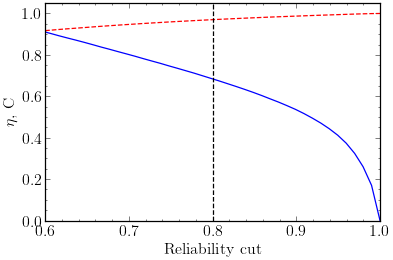

Completeness of all candidates at the given reliability cutoff = 68.412
Completeness of galaxies at the given reliability cutoff = 75.326


In [14]:
# Determining the completeness and cleanness as a function of reliability
reliability_range = np.linspace(0, 1, 100)

# Calculating eta and C for a range of minimum reliability thresholds
eta_range = []
c_range = []
for r in tqdm(reliability_range, desc='Completeness and Cleanness calculations'):
    eta = utils.completeness(sources, 'reliability', 'F250BEST', 'E250BEST', q0, r)
    c = utils.cleanness(sources, 'reliability', r)
    eta_range.append(eta)
    c_range.append(c)

# Completeness and cleanness plot
plt.figure()
plt.plot(reliability_range, eta_range, color = 'b', marker = 'None')
plt.plot(reliability_range, c_range, color = 'r', marker = 'None', linestyle = '--')
plt.axvline(0.8, color = 'k', linestyle = '--')
plt.xticks([0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlabel('Reliability cut')
plt.ylabel(r'$\eta$, C')
plt.xlim(0.6, 1)
plt.ylim(0, 1.05)
plt.show()

# Completeness values at the R > 0.8 cutoff
eta_08 = utils.completeness(sources, 'reliability', 'F250BEST', 'E250BEST', q0, 0.8)*100
eta_08_gal = utils.completeness(galaxy_sources, 'reliability', 'F250BEST', 'E250BEST', q0_gals, 0.8)*100
print("Completeness of all candidates at the given reliability cutoff = {:.3f}".format(eta_08))
print("Completeness of galaxies at the given reliability cutoff = {:.3f}".format(eta_08_gal))

#### Counterpart Colours

We split the counterparts into three bins of colour: Blue - $S_{250}/S_{350} > 1.8$, Green - 1.3 > $S_{250}/S_{350} > 1.8$ and Red - $S_{250}/S_{350} < 1.3$. We then compare the likelihood ratios and reliabilities of these groups.

C:\Users\bradl\AppData\Local\Temp/ipykernel_15524/1680211282.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0, 200)
C:\Users\bradl\AppData\Local\Temp/ipykernel_15524/1680211282.py:37: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(ymin = 0)


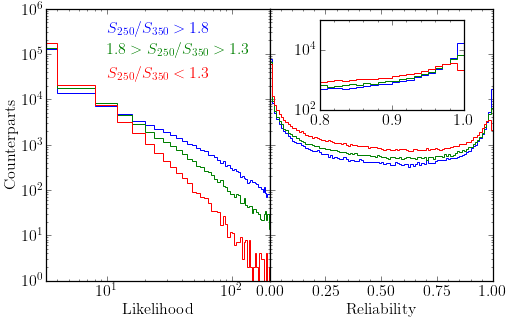

In [15]:
# Splitting all the counterparts into colours
red, green, blue = utils.colour_split(data, 'F250BEST', 'F350BEST', 1.3, 1.8)

# Plot of likelihood ratios and reliabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 5), sharey=True)
fig.subplots_adjust(wspace = 0)

left, bottom, width, height = [0.6, 0.6, 0.25, 0.25]
ax3 = fig.add_axes([left, bottom, width, height])

ax1.hist(blue['likelihood'], bins = 50, range = (0, 200), color = 'b', histtype = 'step')
ax1.hist(green['likelihood'], bins = 50, range = (0, 200), color = 'g', histtype = 'step')
ax1.hist(red['likelihood'], bins = 50, range = (0, 200), color = 'r', histtype = 'step')
ax1.loglog()
ax1.set_xlim(0, 200)
ax1.text(10, 3e5, r'$S_{250}/S_{350} > 1.8$', color = 'b')
ax1.text(10, 1e5, r'$1.8 > S_{250}/S_{350} > 1.3$', color = 'g')
ax1.text(10, 3e4, r'$S_{250}/S_{350} < 1.3$', color = 'r')
ax1.set_xlabel('Likelihood')
ax1.set_ylabel('Counterparts')

ax2.hist(blue['reliability'], bins = 100, range = (0, 1), color = 'b', histtype = 'step')
ax2.hist(green['reliability'], bins = 100, range = (0, 1), color = 'g', histtype = 'step')
ax2.hist(red['reliability'], bins = 100, range = (0, 1), color = 'r', histtype = 'step')
ax2.semilogy()
ax2.set_xlim(0, 1)
ax2.set_ylim(1e0, 1e6)
ax2.set_xlabel('Reliability')

ax3.hist(blue['reliability'], bins = 100, range = (0, 1), color = 'b', histtype = 'step')
ax3.hist(green['reliability'], bins = 100, range = (0, 1), color = 'g', histtype = 'step')
ax3.hist(red['reliability'], bins = 100, range = (0, 1), color = 'r', histtype = 'step')
ax3.semilogy()
ax3.set_xlim(0.8, 1)
ax3.set_ylim(1e2, 1e5)

plt.ylim(ymin = 0)
plt.show()

#### Reliable percentage

We consider the number of SPIRE sources and those that have a reliable match as a function of the number of candidate IDs.

In [16]:
# Generate a table for the multiplicity of sources
table = utils.multiplicity_reliability(sources, 'GroupID', 'GroupSize', 'DISTANCE', 'reliability')
print(table)

+-----------+----------+--------------+---------------------+--------------------+
| N (Match) | N (Data) | N (Reliable) | Reliable Percentage | Average Separation |
+-----------+----------+--------------+---------------------+--------------------+
|     0     |   9890   |      0       |         0.00        |        0.00        |
|     1     |  37263   |    26266     |        70.49        |        4.14        |
|     2     |  49906   |    32496     |        65.11        |        3.31        |
|     3     |  41364   |    22601     |        54.64        |        3.03        |
|     4     |  25524   |    11717     |        45.91        |        2.87        |
|     5     |  13269   |     5410     |        40.77        |        2.75        |
|     6     |   6323   |     2329     |        36.83        |        2.63        |
|     7     |   3107   |     1155     |        37.17        |        2.55        |
|     8     |   1749   |     631      |        36.08        |        2.38        |
|   

### Source Counts

#### Importing Counts and Models

In [17]:
# Importing the Cai et al, 2013 models
# Euclidean-normalized source counts
cai_euc250 = utils.full_loader('/cai_model_mu12/dNdSeuc_250micron_mumax12')
cai_euc350 = utils.full_loader('/cai_model_mu12/dNdSeuc_350micron_mumax12')
cai_euc500 = utils.full_loader('/cai_model_mu12/dNdSeuc_500micron_mumax12')

# Integrated source counts
cai_cum500 = utils.full_loader('/cai_model_mu12/NgtS_500micron_mumax12')

# Importing the DR1 and DR2 data files
dr1 = utils.full_loader('/counts/DR1')
dr2 = utils.full_loader('/counts/DR2')

# Importing Bethermin et al, 2012 counts
bethermin_euc = utils.full_loader('/counts/Bethermin2012_euc')

# Importing Valiante et al, 2016 counts
valiante_euc = utils.full_loader('/counts/Valiante2016_euc')

C:\Users\bradl\AppData\Local\Temp/ipykernel_15524/291510846.py:11: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  dr1 = utils.full_loader('/counts/DR1')
C:\Users\bradl\AppData\Local\Temp/ipykernel_15524/291510846.py:12: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  dr2 = utils.full_loader('/counts/DR2')


#### Herschel-ATLAS Data Release Source Counts

In [18]:
# Number of data points
n = 10

# 4 sigma flux density limits
flux_limit250 = 29.4
flux_limit350 = 37.4
flux_limit500 = 40.6

# Survey areas (square degrees)
dr1_area = 162
dr2_area = 177
dr3_area = 303

# Setup list of flux densities and their limits
fluxes = ['F250BEST', 'F350BEST', 'F500BEST']
flux_limits = [flux_limit250, flux_limit350, flux_limit500]

In [19]:
# Euclidean counts for DR1 DR2 and DR3

# DR1
dr1_euc = {}
for flux,flux_limit in zip(fluxes, flux_limits):
    euclidean_dict = utils.euclidean_counts(dr1, flux, (flux_limit, 600), n, dr1_area)
    dr1_euc[flux] = euclidean_dict

# DR2
dr2_euc = {}
for flux,flux_limit in zip(fluxes, flux_limits):
    euclidean_dict = utils.euclidean_counts(dr2, flux, (flux_limit, 600), n, dr2_area)
    dr2_euc[flux] = euclidean_dict

# DR3
dr3_euc = {}
for flux,flux_limit in zip(fluxes, flux_limits):
    euclidean_dict = utils.euclidean_counts(sources, flux, (flux_limit, 600), n, dr3_area)
    dr3_euc[flux] = euclidean_dict


#### Literature Source Counts

In [20]:
# Collate Cai et al. model counts
cai_euc250['S'] = 10**cai_euc250['log(S)']
cai_euc350['S'] = 10**cai_euc350['log(S)']
cai_euc500['S'] = 10**cai_euc500['log(S)']
cai_euc250['total'] = np.log10(10**cai_euc250['log(latetype)'] + 10**cai_euc250['log(unlensed)'] + 10**cai_euc250['log(lensed)'])
cai_euc350['total'] = np.log10(10**cai_euc350['log(latetype)'] + 10**cai_euc350['log(unlensed)'] + 10**cai_euc350['log(lensed)'])
cai_euc500['total'] = np.log10(10**cai_euc500['log(latetype)'] + 10**cai_euc500['log(unlensed)'] + 10**cai_euc500['log(lensed)'])

# Collate Bethermin et al. source counts (Note that the logarithm [base 10] of an error del(x) is 0.434*del(x)/x)
bethermin_fluxrange = bethermin_euc['S']
bethermin_euc250 = np.log10(bethermin_euc['euc250'])
bethermin_euc350 = np.log10(bethermin_euc['euc350'])
bethermin_euc500 = np.log10(bethermin_euc['euc500'])
bethermin_euclow_250 = bethermin_euchigh_250 = 0.434*(bethermin_euc['euc250_err']/bethermin_euc['euc250'])
bethermin_euclow_350 = bethermin_euchigh_350 = 0.434*(bethermin_euc['euc350_err']/bethermin_euc['euc350'])
bethermin_euclow_500 = bethermin_euchigh_500 = 0.434*(bethermin_euc['euc500_err']/bethermin_euc['euc500'])

# Collate Valiante et al. source counts
g09_areadeg, g12_areadeg, g15_areadeg = 53.43*(u.deg**2), 53.56*(u.deg**2), 54.56*(u.deg**2)
g09_areasr, g12_areasr, g15_areasr = g09_areadeg.to(u.steradian), g12_areadeg.to(u.steradian), g15_areadeg.to(u.steradian)
gama_areasr = g09_areasr + g12_areasr + g15_areasr

def valiante_counts(g09, g12, g15, g09_err, g12_err, g15_err):
    """ The function turns Jy^1.5 deg^-2 counts for G09, G12 and G15 fields
        into total GAMA Jy^1.5 sr^-1 counts, remembering that the error of a logarithm
        (base 10) del(x) is 0.434*del(x)/x """

    g09_sr, g12_sr, g15_sr = g09*g09_areadeg.value, g12*g12_areadeg.value, g15*g15_areadeg.value
    g09err_sr, g12err_sr, g15err_sr = g09_err*g09_areadeg.value, g12_err*g12_areadeg.value, g15_err*g15_areadeg.value
    total_counts = (g09_sr + g12_sr + g15_sr)/gama_areasr
    total_error = (np.sqrt((g09err_sr**2) + (g12err_sr**2) + (g15err_sr**2)))/gama_areasr
    log_counts = np.log10(total_counts)
    log_error = 0.434*(total_error/total_counts)
    return log_counts, log_error, log_error

valiante_fluxrange = valiante_euc['S']
valiante_euc250, valiante_euclow_250, valiante_euchigh_250 = valiante_counts(valiante_euc['G09_total250'], valiante_euc['G12_total250'], valiante_euc['G15_total250'], valiante_euc['G09_totalerr250'], valiante_euc['G12_totalerr250'], valiante_euc['G15_totalerr250'])
valiante_euc350, valiante_euclow_350, valiante_euchigh_350 = valiante_counts(valiante_euc['G09_total350'], valiante_euc['G12_total350'], valiante_euc['G15_total350'], valiante_euc['G09_totalerr350'], valiante_euc['G12_totalerr350'], valiante_euc['G15_totalerr350'])
valiante_euc500, valiante_euclow_500, valiante_euchigh_500 = valiante_counts(valiante_euc['G09_total500'], valiante_euc['G12_total500'], valiante_euc['G15_total500'], valiante_euc['G09_totalerr500'], valiante_euc['G12_totalerr500'], valiante_euc['G15_totalerr500'])

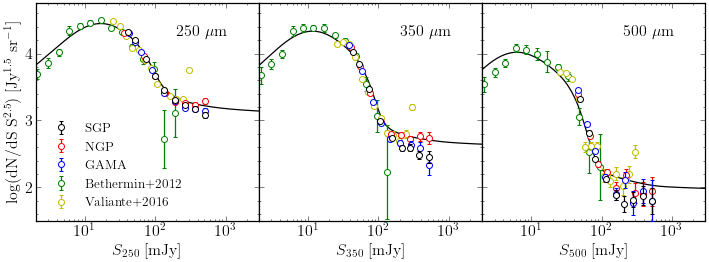

In [21]:
# Plots of the Euclidean counts
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (12, 4))
fig.subplots_adjust(wspace = 0)

flux_range = np.linspace(0, 10000, 10000)

ax1.errorbar(dr3_euc['F250BEST']['flux'], dr3_euc['F250BEST']['euclidean_counts'], yerr = (dr3_euc['F250BEST']['error_low'], dr3_euc['F250BEST']['error_high']), marker = 'o', linestyle = '', label = 'SGP', zorder = 6)
ax1.errorbar(dr2_euc['F250BEST']['flux'], dr2_euc['F250BEST']['euclidean_counts'], yerr = (dr2_euc['F250BEST']['error_low'], dr2_euc['F250BEST']['error_high']), marker = 'o', linestyle = '', label = 'NGP', zorder = 4)
ax1.errorbar(dr1_euc['F250BEST']['flux'], dr1_euc['F250BEST']['euclidean_counts'], yerr = (dr1_euc['F250BEST']['error_low'], dr1_euc['F250BEST']['error_high']), marker = 'o', linestyle = '', label = 'GAMA', zorder = 5)
ax1.errorbar(bethermin_fluxrange, bethermin_euc250, yerr = (bethermin_euclow_250, bethermin_euchigh_250), marker = 'o', linestyle = '', label = 'Bethermin+2012', zorder = 2)
ax1.errorbar(valiante_fluxrange, valiante_euc250, yerr = (valiante_euclow_250, valiante_euchigh_250), marker = 'o', linestyle = '', label = 'Valiante+2016', zorder = 3)
ax1.plot(cai_euc250['S'], cai_euc250['total'], marker = 'None', linestyle = '-', color = 'k', zorder = 1)
ax1.text(200, 4.25, r'250 $\mu$m')
ax1.set_ylabel(r'log(dN/dS S$^{2.5}$) [Jy$^{1.5}$ sr$^{-1}$]')
ax1.set_xlabel(r'$S_{250}$ [mJy]')
ax1.legend()

ax2.errorbar(dr3_euc['F350BEST']['flux'], dr3_euc['F350BEST']['euclidean_counts'], yerr = (dr3_euc['F350BEST']['error_low'], dr3_euc['F350BEST']['error_high']), marker = 'o', linestyle = '', label = 'SGP', zorder = 6)
ax2.errorbar(dr2_euc['F350BEST']['flux'], dr2_euc['F350BEST']['euclidean_counts'], yerr = (dr2_euc['F350BEST']['error_low'], dr2_euc['F350BEST']['error_high']), marker = 'o', linestyle = '', label = 'NGP', zorder = 4)
ax2.errorbar(dr1_euc['F350BEST']['flux'], dr1_euc['F350BEST']['euclidean_counts'], yerr = (dr1_euc['F350BEST']['error_low'], dr1_euc['F350BEST']['error_high']), marker = 'o', linestyle = '', label = 'GAMA', zorder = 5)
ax2.errorbar(bethermin_fluxrange, bethermin_euc350, yerr = (bethermin_euclow_350, bethermin_euchigh_350), marker = 'o', linestyle = '', label = 'Bethermin+2012', zorder = 2)
ax2.errorbar(valiante_fluxrange, valiante_euc350, yerr = (valiante_euclow_350, valiante_euchigh_350), marker = 'o', linestyle = '', label = 'Valiante+2016', zorder = 3)
ax2.plot(cai_euc350['S'], cai_euc350['total'], marker = 'None', linestyle = '-', color = 'k', zorder = 1)
ax2.text(200, 4.25, r'350 $\mu$m')
ax2.set_xlabel(r'$S_{350}$ [mJy]')

ax3.errorbar(dr3_euc['F500BEST']['flux'], dr3_euc['F500BEST']['euclidean_counts'], yerr = (dr3_euc['F500BEST']['error_low'], dr3_euc['F500BEST']['error_high']), marker = 'o', linestyle = '', label = 'SGP', zorder = 6)
ax3.errorbar(dr2_euc['F500BEST']['flux'], dr2_euc['F500BEST']['euclidean_counts'], yerr = (dr2_euc['F500BEST']['error_low'], dr2_euc['F500BEST']['error_high']), marker = 'o', linestyle = '', label = 'NGP', zorder = 4)
ax3.errorbar(dr1_euc['F500BEST']['flux'], dr1_euc['F500BEST']['euclidean_counts'], yerr = (dr1_euc['F500BEST']['error_low'], dr1_euc['F500BEST']['error_high']), marker = 'o', linestyle = '', label = 'GAMA', zorder = 5)
ax3.errorbar(bethermin_fluxrange, bethermin_euc500, yerr = (bethermin_euclow_500, bethermin_euchigh_500), marker = 'o', linestyle = '', label = 'Bethermin+2012', zorder = 2)
ax3.errorbar(valiante_fluxrange, valiante_euc500, yerr = (valiante_euclow_500, valiante_euchigh_500), marker = 'o', linestyle = '', label = 'Valiante+2016', zorder = 3)
ax3.plot(cai_euc500['S'], cai_euc500['total'], marker = 'None', linestyle = '-', color = 'k', zorder = 1)
ax3.text(200, 4.25, r'500 $\mu$m')
ax3.set_xlabel(r'$S_{500}$ [mJy]')
ax3.set_xlim(2e0, 3e3)
ax3.set_ylim(1.5, 4.75)
ax3.semilogx()

plt.xticks([1e1, 1e2, 1e3])
plt.show()


### Output Tables

In [22]:
# Output new data single IDs table
t_sources = Table.from_pandas(sources)
t_sources.write('C:/Users/bradl/Desktop/HerschelATLASDR3_2/data/data_single_IDs' + '_' + '{}'.format(R), overwrite = True, format = 'csv')

# Output new data all IDs table
t_data = Table.from_pandas(data)
t_data.write('C:/Users/bradl/Desktop/HerschelATLASDR3_2/data/data_all_IDs' + '_' + '{}'.format(R), overwrite = True, format = 'csv')

# Output new background all IDs table
t_back = Table.from_pandas(background)
t_back.write('C:/Users/bradl/Desktop/HerschelATLASDR3_2/data/background_all_IDs' + '_' + '{}'.format(R), overwrite = True, format = 'csv')